### Import all necessary packages

In [1]:
import numpy as np
import cv2
from PIL import Image
import pytesseract as tess
import pandas as pd
from skimage.io import imread, imshow
from skimage.segmentation import clear_border
import imutils
import os

In [2]:
from functions import *

In [3]:
test_func()

Functions are ready!


### Question 1:  Rename and list all files of the dataset into files_list.csv

In [4]:
filenames = os.listdir('./dataset')
    
ques1 = pd.DataFrame(columns=['Filename'])
ques1['Filename'] = filenames
ques1.to_csv('files_list.csv')

### Question 2: From the original images, create a new image with highlighted license plate's characters and save into a folder.

In [5]:
create_new_folder('blackhat_morph')

In [6]:
read_path = './dataset/'
save_path = './blackhat_morph/'
blackhat_list = []

for fi in filenames:
    path1 = read_path + fi
    image = imread(path1)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, blackhat = blackhat_morph(gray)
    blackhat_list.append((fi, blackhat))
    
save_files(save_path, blackhat_list)

### Question 3: Locate potential regions (white regions) of the license plate in the image and save into a folder.

In [7]:
create_new_folder('potential_regions')

In [8]:
read_path = './dataset/'
save_path = './potential_regions/'
regions_list = []

for fi in filenames:
    path1 = read_path + fi
    image = imread(path1)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rectKern, blackhat = blackhat_morph(gray)
    
    light_mask = find_light_mask(gray)
    
    regions_img = find_potential_regions(blackhat, rectKern, light_mask)
    regions_list.append((fi, regions_img))
    
save_files(save_path, regions_list)

### Question 4: Identify the region that contain the license plate by applying aspect ratio (width/height) of each region. Draw contours on that region in the original image and save into a folder.

In [9]:
create_new_folder('drawn_CLP_cnts')

In [10]:
read_path = './dataset/'
save_path = './drawn_CLP_cnts/'
imgs_w_cnt_list = []

for fi in filenames:
    path1 = read_path + fi
    image = imread(path1)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rectKern, blackhat = blackhat_morph(gray)
    
    light_mask = find_light_mask(gray)
    
    regions_img = find_potential_regions(blackhat, rectKern, light_mask)
    
    cnts = potential_cnts(regions_img, keep=10)
    choose_and_draw(image, cnts)
    imgs_w_cnt_list.append((fi, image))
    
save_files(save_path, imgs_w_cnt_list)

### Question 5: Crop the license plate (binary format for tesseracts reading) from the original image and save into a folder.

In [11]:
create_new_folder('cropped_CLP')

In [12]:
read_path = './dataset/'
save_path = './cropped_CLP/'
cropped_list = []

for fi in filenames:
    path1 = read_path + fi
    image = imread(path1)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rectKern, blackhat = blackhat_morph(gray)
    
    light_mask = find_light_mask(gray)
    
    regions_img = find_potential_regions(blackhat, rectKern, light_mask)
    
    cnts = potential_cnts(regions_img, keep=10)
    
    LP_bitwise = crop_license_plate(gray, cnts)
    cropped_list.append((fi, LP_bitwise))
    
save_files(save_path, cropped_list)

### Question 6: Read the characters from cropped-license-plate images using Tesseracts-OCR (Optical Character Recognition) and save Filename - LicenseChars into a csv file.

In [13]:
psm = 7
alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
options = "-c tessedit_char_whitelist={}".format(alphanumeric)
options += " --psm {}".format(psm)

tess.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

license_chars = []

for i in cropped_list:
    LP_text = None
    LP = i[1]
    
    if LP is not None:
        LP_text = tess.image_to_string(LP, config=options)
        license_chars.append(LP_text)

In [14]:
result_1 = pd.DataFrame(columns=['Filename', 'LicenseChars'])
result_1['Filename'] = filenames
result_1['LicenseChars'] = license_chars

result_1.to_csv('result_1.csv', index=False)

### Question 7: From result_1.csv, add 1 new column "Letters-Only" to check if the license plate contain letters only or both letters and digits. Save this into a new csv file.

In [15]:
result_2 = pd.read_csv('result_1.csv')
check = []

for i in license_chars:
    if any(map(str.isdigit, i)):
        check.append(False)
    else:
        check.append(True)
        
result_2['Letters-Only'] = check
result_2.to_csv('result_2.csv', index=False)

### Question 8: Create a new column called "points" with the unit digit of sum of the all digits.

In [16]:
result_3 = pd.read_csv('result_2.csv')
points = []

for i in range(len(result_3)):
    row = result_3.iloc[i]
    if row['Letters-Only'] == True:
        points.append(0)
    else:
        points.append(calc_points(row['LicenseChars']))
        
result_3['Points'] = points
result_3.to_csv('result_3.csv', index=False)

### Question 9: Create a new column called "lucky". A license plate is "lucky" if it has progressive numbers in sequence and more than 5 points.

In [17]:
result_4 = pd.read_csv('result_3.csv')
lucky = []

for i in range(len(result_4)):
    row = result_3.iloc[i]
    point = row['Points']
    if point >= 5:
        lucky.append(check_lucky(row['LicenseChars']))
    else:
        lucky.append(False)
        
result_4['Lucky'] = lucky
result_4.to_csv('result_4.csv', index=False)

### Question 10: User enters a desired point. Randomly give the user 1 license plate with that point ("lucky" is preferable).

Enter you desired point of the car license plate: 6
This is (your car) with suitable license plate:


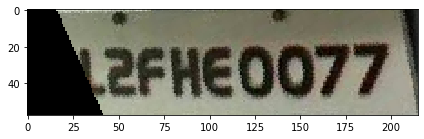

In [19]:
import random

desired = int(input('Enter you desired point of the car license plate: '))

options = pd.read_csv('result_4.csv')
options = options[options['Points'] == desired]

if len(options) == 0:
    print('Sorry, we do not have your desired point!')
else:
    lucky_options = options[options['Lucky'] == True]
    if len(lucky_options) == 0:
        filename = options.sample()['Filename'].item()
    else:
        filename = lucky_options.sample()['Filename'].item()
        
    path = './dataset/' + filename
    option = imread(path)
    print('This is (your car) with suitable license plate:')
    imshow(option)